# Введение

Нас (возможно и вас) пригласили поучаствовать в одном из проектов UNICEF — международного подразделения ООН, чья миссия состоит в повышении уровня благополучия детей по всему миру. 

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import scipy.stats
import itertools as it

# Ознакомление
Для начала загрузим файл в датафрейм (ДФ), переименуем некоторые колонки для удобства и посмотрим развернутый ДФ.

In [89]:
df = pd.read_csv('stud_math.csv')
df.rename(columns={'studytime, granular': 'studytime_granular',
                         'Pstatus': 'pstatus', 'Medu': 'medu', 'Fedu': 'fedu',
                         'Mjob': 'mjob', 'Fjob': 'fjob'}, inplace=True)
pd.set_option('max_columns', None)

In [90]:
df.sample(10)

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
72,GP,F,15,R,GT3,T,1.0,1.0,other,other,reputation,mother,1.0,2.0,2.0,yes,yes,no,no,no,-6.0,yes,yes,yes,NaN,3.0,4.0,5.0,2.0,25.0
170,GP,M,16,U,GT3,T,3.0,4.0,other,other,course,father,3.0,1.0,NaN,no,yes,no,yes,no,-3.0,NaN,yes,no,3.0,4.0,5.0,2.0,0.0,0.0
120,GP,F,15,U,GT3,T,1.0,2.0,at_home,NaN,course,mother,1.0,2.0,0.0,no,no,no,no,no,-6.0,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0
63,GP,F,16,U,GT3,NaN,4.0,3.0,teacher,health,NaN,mother,1.0,3.0,0.0,yes,yes,yes,yes,yes,-9.0,yes,yes,no,3.0,4.0,4.0,4.0,2.0,45.0
58,GP,M,15,U,LE3,T,1.0,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
273,GP,M,17,R,GT3,T,1.0,2.0,at_home,at_home,home,mother,1.0,2.0,0.0,no,yes,yes,yes,no,-6.0,yes,NaN,yes,3.0,5.0,2.0,1.0,2.0,70.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
280,GP,M,17,U,NaN,A,4.0,NaN,services,other,home,mother,2.0,1.0,NaN,no,no,yes,yes,yes,-3.0,yes,yes,NaN,4.0,NaN,4.0,5.0,30.0,40.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0


#### Значения колонок датафрейма

school — аббревиатура школы, в которой учится ученик

sex — пол ученика ('F' - женский, 'M' - мужской)

age — возраст ученика (от 15 до 22)

address — тип адреса ученика ('U' - городской, 'R' - за городом)

famsize — размер семьи('LE3' <= 3, 'GT3' >3)

Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)

traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

schoolsup — дополнительная образовательная поддержка (yes или no)

famsup — семейная образовательная поддержка (yes или no)

paid — дополнительные платные занятия по математике (yes или no)

activities — дополнительные внеучебные занятия (yes или no)

nursery — посещал детский сад (yes или no)

higher — хочет получить высшее образование (yes или no)

internet — наличие интернета дома (yes или no)

romantic — в романтических отношениях (yes или no)

famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)

goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

absences — количество пропущенных занятий

score — баллы по госэкзамену по математике

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   pstatus             350 non-null    object 
 6   medu                392 non-null    float64
 7   fedu                371 non-null    float64
 8   mjob                376 non-null    object 
 9   fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

In [92]:
# Посмотрим кол-во пропусков в колонках
df.isna().sum()

school                 0
sex                    0
age                    0
address               17
famsize               27
pstatus               45
medu                   3
fedu                  24
mjob                  19
fjob                  36
reason                17
guardian              31
traveltime            28
studytime              7
failures              22
schoolsup              9
famsup                39
paid                  40
activities            14
nursery               16
studytime_granular     7
higher                20
internet              34
romantic              31
famrel                27
freetime              11
goout                  8
health                15
absences              12
score                  6
dtype: int64

В датасете всего 30 колонок: 13 числовых колонок и 17 строковых. 
Датасете содержит данные данные о 395 учениках.
Во всех колонках, кроме school, sex, age есть пустые значения.

### Предобработка

In [93]:
# Функция для получения быстрой справки о данных в числовых колонках
def info_dig(x):
    print(pd.DataFrame(x.value_counts()))
    print('Пропущенных значений -', x.isnull().values.sum())
    x.hist()

In [94]:
# Функция для получения быстрой справки о данных в текстовых колонках
def info_object(smth):
    print(pd.DataFrame(smth.value_counts()))
    print('Пропущенных значений -', smth.isnull().values.sum())
    sns.boxplot(x=smth, y='score', data=df)

### Просмотр числовыx столбцов

    age
16  104
17   98
18   82
15   82
19   24
20    3
22    1
21    1
Пропущенных значений - 0


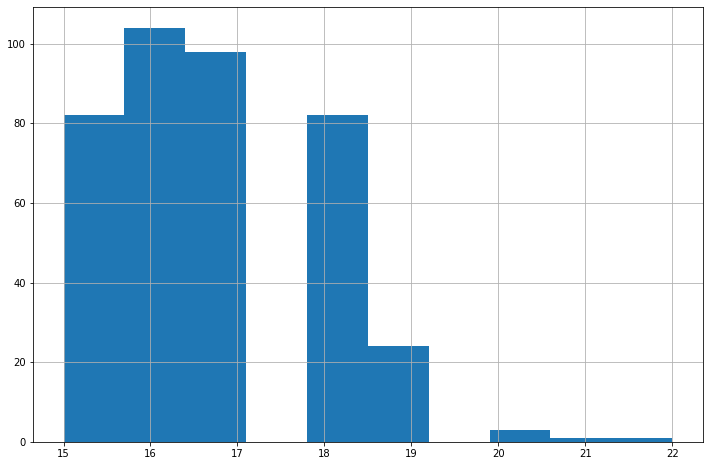

In [95]:
info_dig(df.age)

     medu
4.0   131
2.0   102
3.0    97
1.0    59
0.0     3
Пропущенных значений - 3


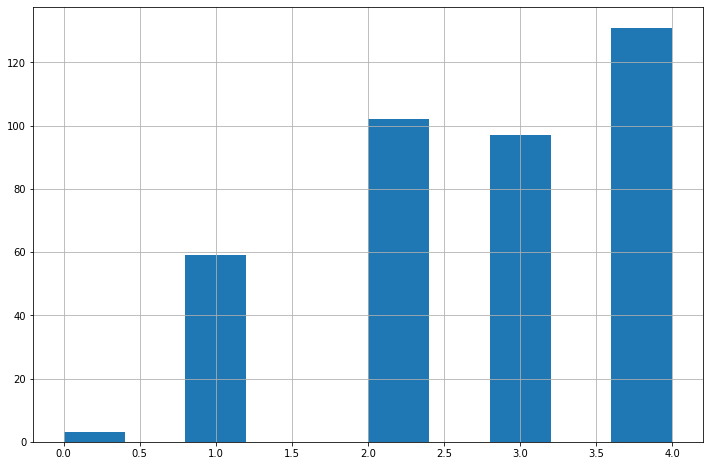

In [96]:
info_dig(df.medu)

In [97]:
# Заполним пропуски средним значением
df.medu.fillna(round(df.medu.mean()), inplace=True)

      fedu
2.0    106
3.0     96
4.0     88
1.0     78
0.0      2
40.0     1
Пропущенных значений - 24


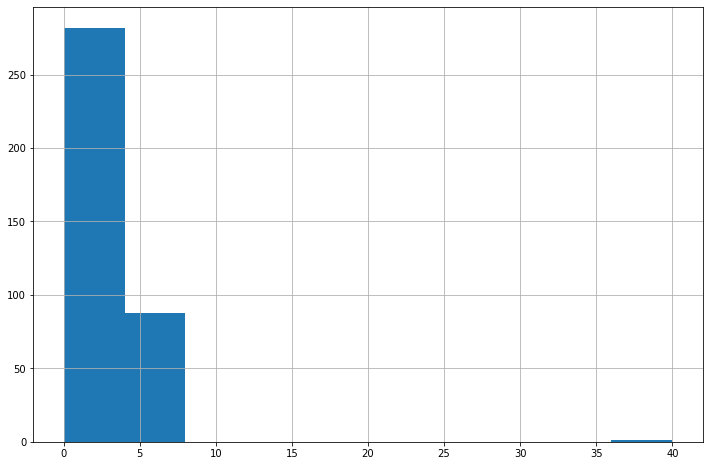

In [98]:
info_dig(df.fedu)

In [99]:
# Исправим опечатку значения 40.0, вероятно имелось ввиду 4.
df.fedu = df.fedu.apply(lambda x: x/10 if x > 9 else x)

In [100]:
# Заполним пропуски средним значением
df.fedu.fillna(round(df.fedu.mean()), inplace=True)

     traveltime
1.0         242
2.0          96
3.0          22
4.0           7
Пропущенных значений - 28


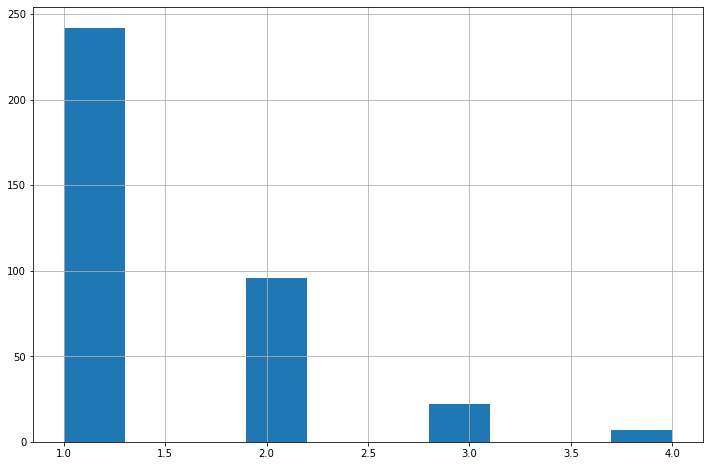

In [101]:
info_dig(df.traveltime)

In [102]:
# Заполним пропуски средним значением
df.traveltime.fillna(round(df.traveltime.mean()), inplace=True)

     studytime
2.0        194
1.0        103
3.0         64
4.0         27
Пропущенных значений - 7


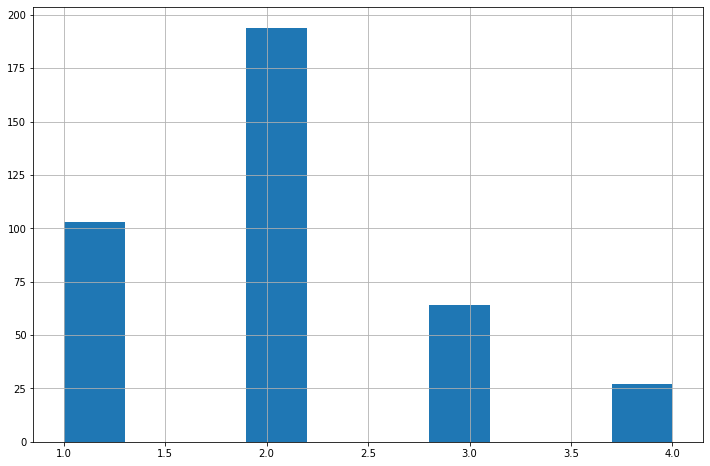

In [103]:
info_dig(df.studytime)

In [104]:
# Заполним пропуски средним значением
df.studytime.fillna(round(df.studytime.mean()), inplace=True)

     failures
0.0       293
1.0        49
2.0        16
3.0        15
Пропущенных значений - 22


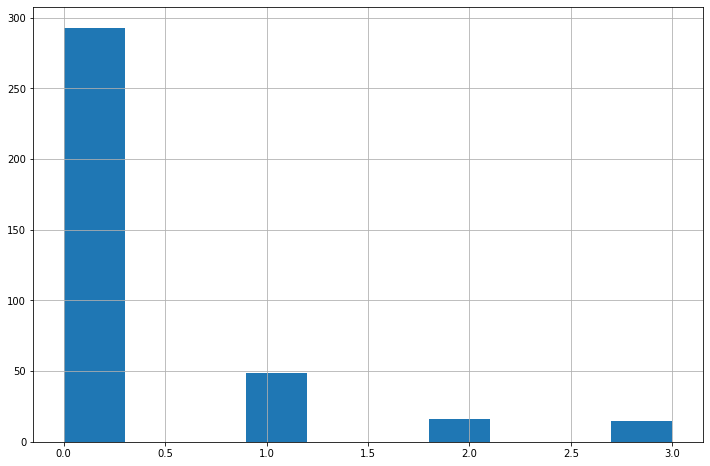

In [105]:
info_dig(df.failures)

In [106]:
# Заполним пропуски средним значением
df.failures.fillna(round(df.failures.mean()), inplace=True)

       studytime_granular
-6.0                  194
-3.0                  103
-9.0                   64
-12.0                  27
Пропущенных значений - 7


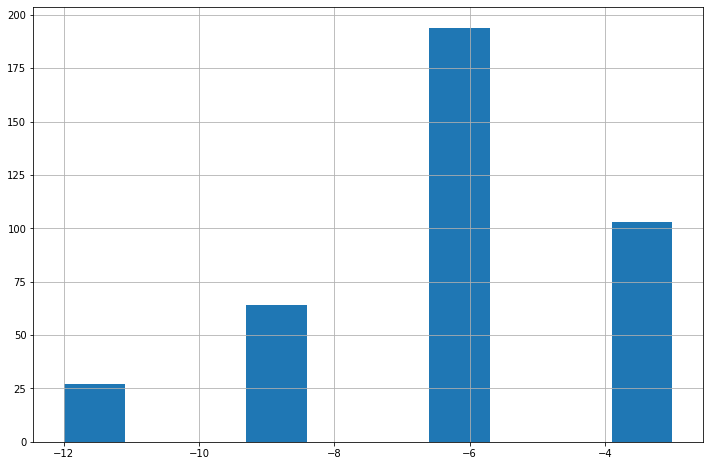

In [107]:
info_dig(df.studytime_granular)

In [108]:
# Заполним пропуски средним значением
df.studytime_granular.fillna(round(df.studytime_granular.mean()), inplace=True)

      famrel
 4.0     182
 5.0      99
 3.0      62
 2.0      17
 1.0       7
-1.0       1
Пропущенных значений - 27


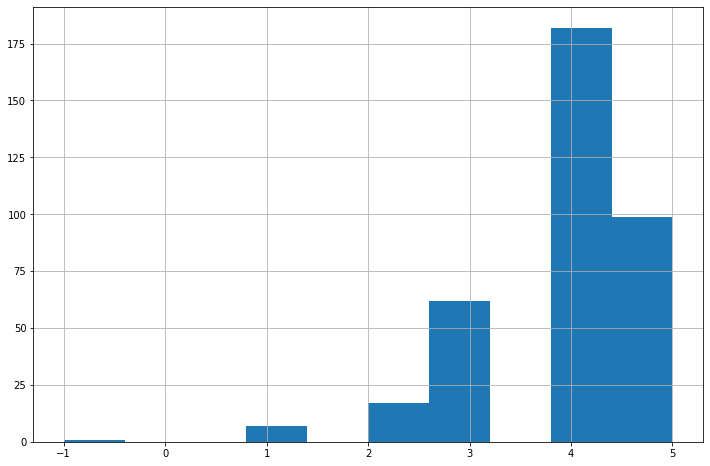

In [109]:
info_dig(df.famrel)

In [110]:
# Исправим опечатку значения -1.0, вероятно имелось ввиду 1.0
df.famrel = df.famrel.apply(lambda x: abs(x) if x < 0 else x)

In [111]:
# Заполним пропуски средним значением
df.famrel.fillna(round(df.famrel.mean()), inplace=True)

     freetime
3.0       153
4.0       112
2.0        63
5.0        38
1.0        18
Пропущенных значений - 11


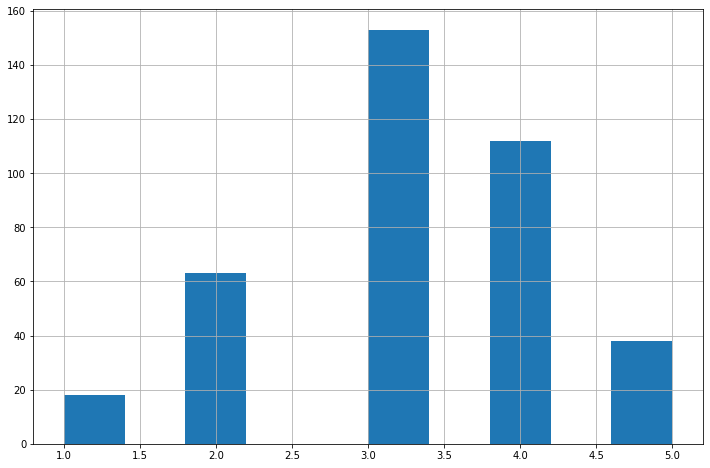

In [112]:
info_dig(df.freetime)

In [113]:
# Заполним пропуски средним значением
df.freetime.fillna(round(df.freetime.mean()), inplace=True)

     goout
3.0    127
2.0    101
4.0     84
5.0     52
1.0     23
Пропущенных значений - 8


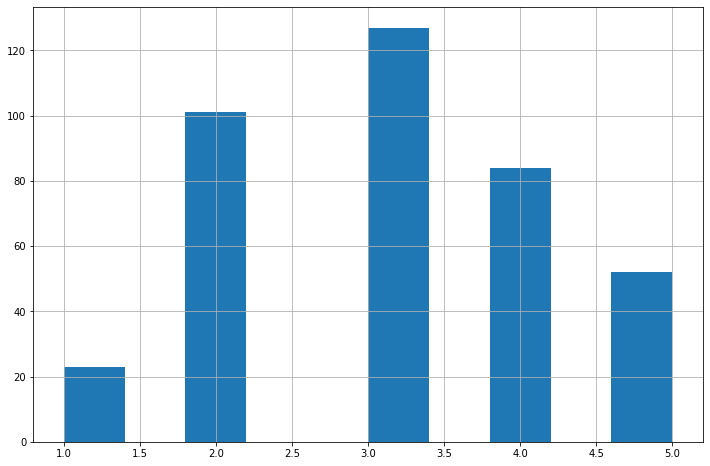

In [114]:
info_dig(df.goout)

In [115]:
# Заполним пропуски средним значением
df.goout.fillna(round(df.goout.mean()), inplace=True)

     health
5.0     138
3.0      89
4.0      63
1.0      47
2.0      43
Пропущенных значений - 15


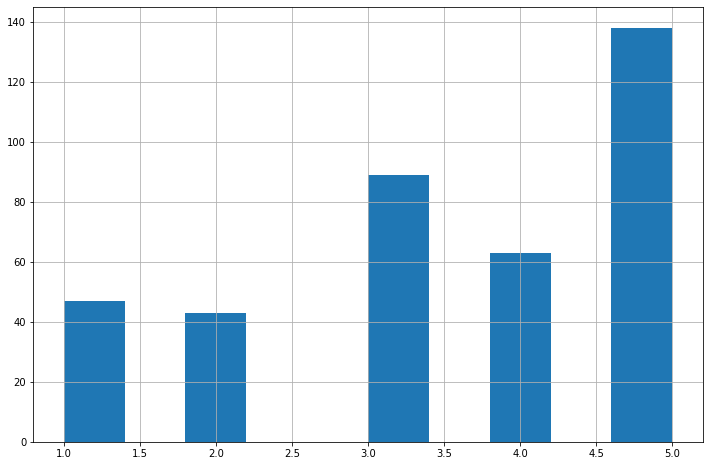

In [116]:
info_dig(df.health)

In [117]:
# Заполним пропуски средним значением
df.health.fillna(round(df.health.mean()), inplace=True)

       absences
0.0         111
2.0          60
4.0          53
6.0          31
8.0          21
10.0         17
12.0         12
14.0         12
3.0           8
16.0          7
7.0           6
5.0           5
18.0          5
20.0          4
22.0          3
9.0           3
1.0           3
15.0          2
13.0          2
11.0          2
25.0          1
54.0          1
385.0         1
26.0          1
56.0          1
24.0          1
212.0         1
21.0          1
75.0          1
30.0          1
19.0          1
38.0          1
40.0          1
23.0          1
17.0          1
28.0          1
Пропущенных значений - 12


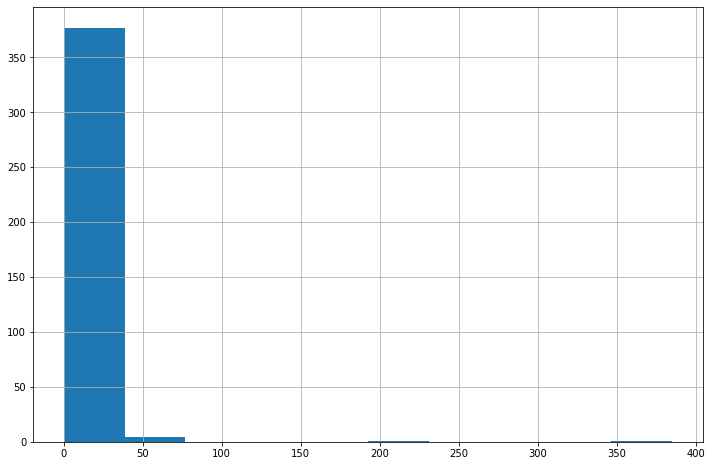

In [118]:
info_dig(df.absences)

In [119]:
# Вероятно, значения 212 и 385 являются ошибками, т.к. выходят за рамки кол-ва учебных дней и кол-ва дней в году соответственно.
# Удалим их из датасета.
df = df[~df.absences.isin([212.0,385.0])]

In [120]:
# Заполним пропуски медианным значением, т.к. достаточно большой разброс
df.absences.fillna(round(df.absences.median()), inplace=True)

      absences
0.0        111
4.0         65
2.0         60
6.0         31
8.0         21
10.0        17
14.0        12
12.0        12
3.0          8
16.0         7
7.0          6
5.0          5
18.0         5
20.0         4
1.0          3
22.0         3
9.0          3
15.0         2
13.0         2
11.0         2
54.0         1
25.0         1
17.0         1
26.0         1
56.0         1
23.0         1
28.0         1
21.0         1
75.0         1
30.0         1
19.0         1
38.0         1
40.0         1
24.0         1
Пропущенных значений - 0


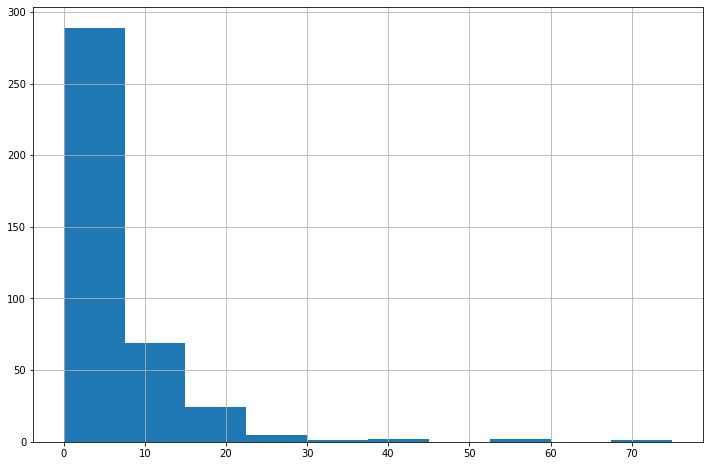

In [121]:
# Посмотрим еще раз не получившийся результат
info_dig(df.absences)

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


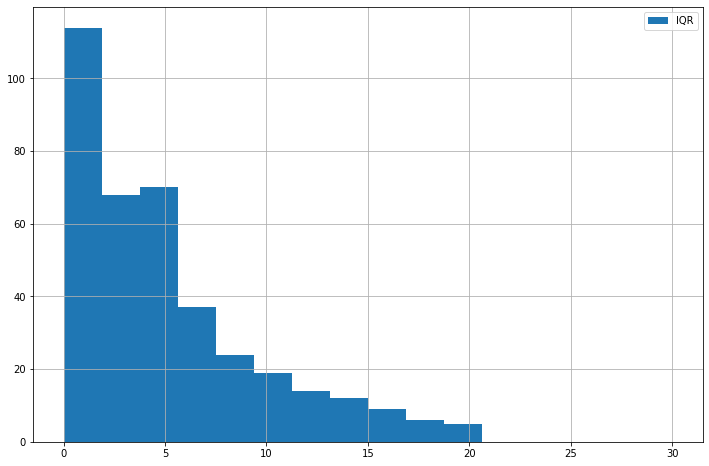

In [122]:
# Определим выбросы и удалим их. Выбросами считаем значения больше 30, 
# т.к. пропуск более 30 учебных дней скорее всего приведет к переводу ученика на домашнее обучение

median = df.absences.median()
IQR = df.absences.quantile(0.75) - df.absences.quantile(0.25)
perc25 = df.absences.quantile(0.25)
perc75 = df.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), 
      '75-й перцентиль: {},'.format(perc75), 
      "IQR: {}, ".format(IQR),
      "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
df.absences.loc[df.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16, 
                                                                              range = (0, 30), 
                                                                              label = 'IQR')
plt.legend();

In [123]:
# Удалим выбросы

df = df[df.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

       score
50.0      54
55.0      42
0.0       37
75.0      33
60.0      31
65.0      30
40.0      28
70.0      27
45.0      23
80.0      16
30.0      14
90.0      10
35.0       9
25.0       7
95.0       5
85.0       5
100.0      1
Пропущенных значений - 6


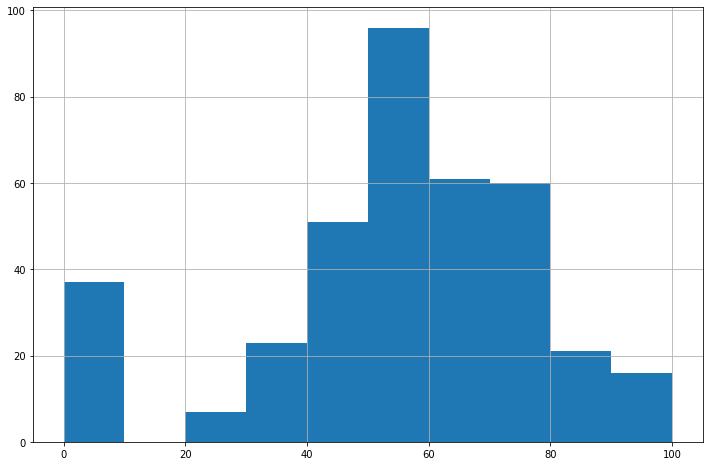

In [124]:
info_dig(df.score)

In [125]:
# Пропуски в целевой переменной можно удалить
df = df[~df.score.isna()]

# Также можно удалить нулевые значения, вероятно ученик просто не явился на экзамен
df = df[df.score > 0.0]

### Просмотр строковых столбцов

    school
GP     295
MS      40
Пропущенных значений - 0


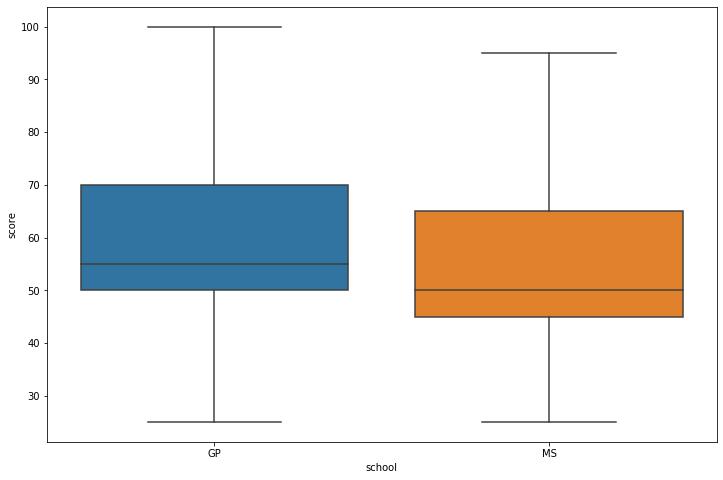

In [126]:
info_object(df.school)

   sex
F  169
M  166
Пропущенных значений - 0


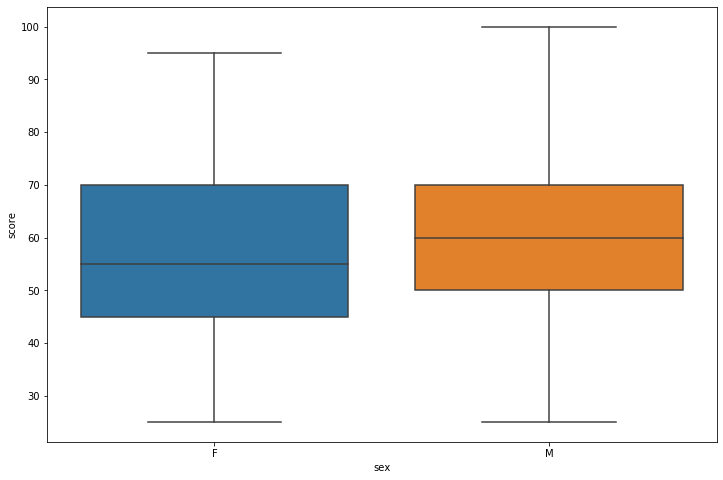

In [127]:
info_object(df.sex)

   address
U      250
R       71
Пропущенных значений - 14


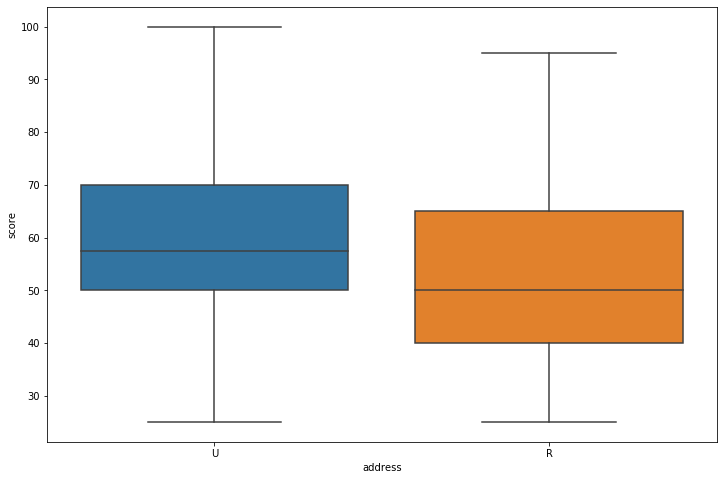

In [128]:
info_object(df.address)

In [129]:
# Чтобы заполнить пропуски найдем среднее время до школы для городских и загородных учеников
df.groupby(['address'])['traveltime'].mean().reset_index()

,address,traveltime
0,R,1.746479
1,U,1.300000


In [130]:
# Т.к. у нас круглые значения в traveltime - будем считать, что 2 и более - это загородные ученики. 
# Заполним пропуски следующим образом:

pd.set_option('mode.chained_assignment', None) # Чтобы не ругался

df = df.reset_index() # Сбросим индекс учеников, иначе алерт
df.address.fillna(0, inplace=True) # Заполним пропуски 0

for i in range(0, len(df)):
    if df.address[i] == 0:
        if df.traveltime[i] > 1.0:
            df.address[i] = 'R'
        else:
            df.address[i] = 'U'

     famsize
GT3      216
LE3       97
Пропущенных значений - 22


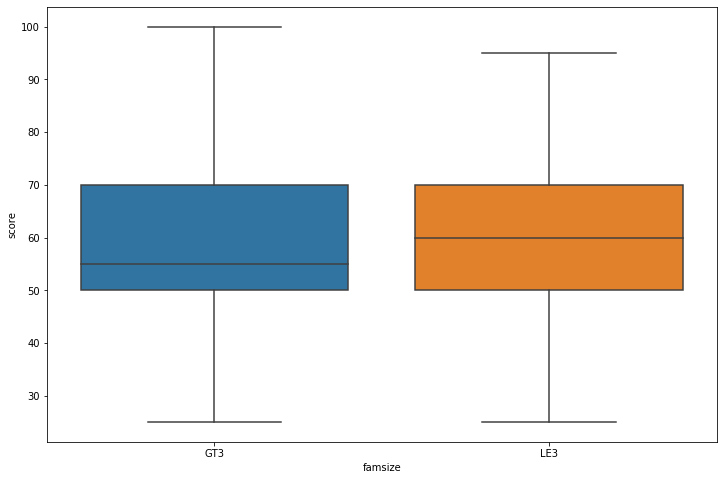

In [131]:
info_object(df.famsize)

In [132]:
# Заполним пропуски самым частовстречаемым значением
# Логическое предположение: родители живут вместе - больше семья
# Для этого обратимся к параметру Pstatus (Совместное проживание родителей)
df.groupby(['pstatus'])['famsize'].value_counts() 

pstatus  famsize
A        GT3         16
         LE3         12
T        GT3        178
         LE3         74
Name: famsize, dtype: int64

In [133]:
# Предположение не оправдалось, во всех группах преобладает значение GT3, им и заполним пропуски
df.famsize.fillna('GT3', inplace=True)

   pstatus
T      269
A       30
Пропущенных значений - 36


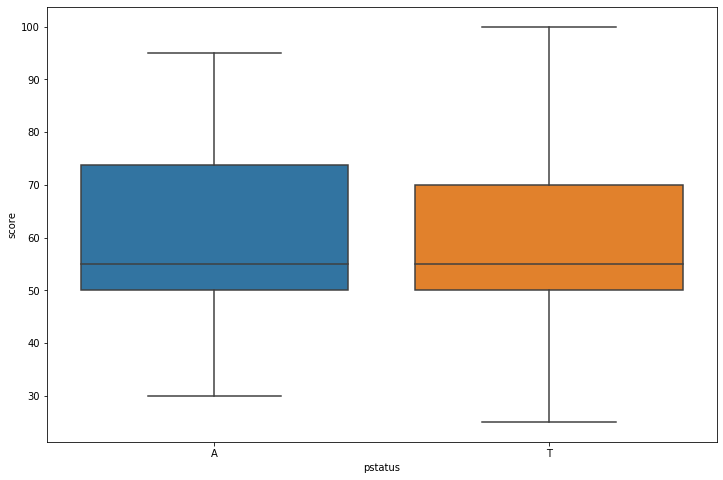

In [134]:
info_object(df.pstatus)

In [135]:
# Заполним пропуски самым частовстречаемым значением
df.pstatus.fillna('T', inplace=True)

          mjob
other      109
services    83
teacher     50
at_home     48
health      30
Пропущенных значений - 15


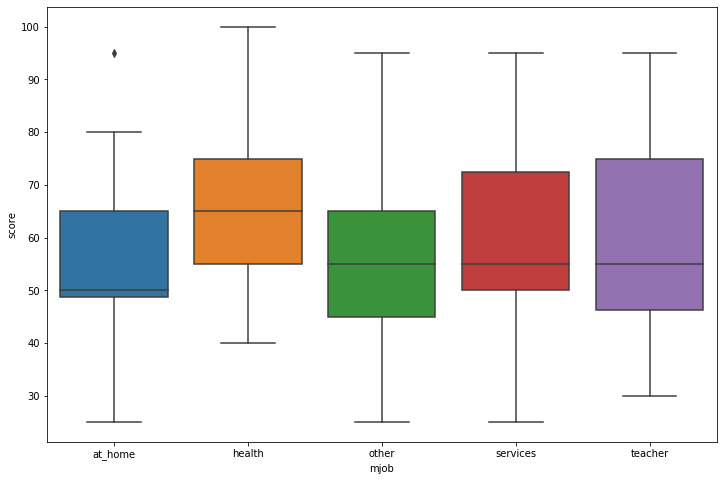

In [136]:
info_object(df.mjob)

In [137]:
# Заполним пропуски неопределенным значением
df.mjob.fillna('other', inplace=True)

          fjob
other      169
services    82
teacher     24
health      15
at_home     14
Пропущенных значений - 31


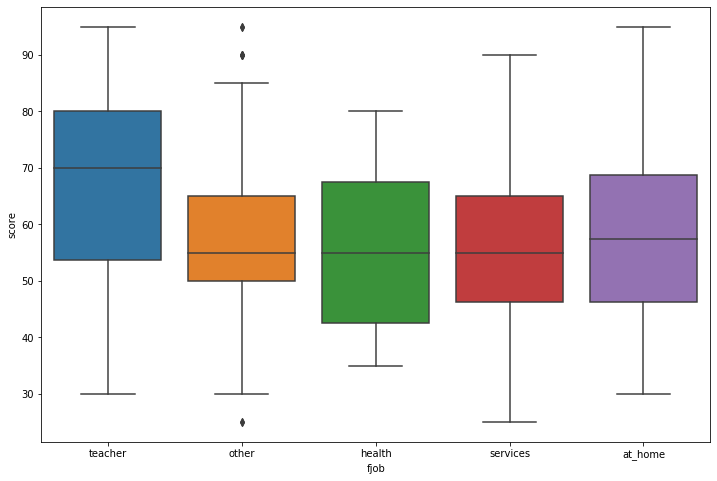

In [138]:
info_object(df.fjob)

In [139]:
# Заполним пропуски неопределенным значением
df.fjob.fillna('other', inplace=True)

            reason
course         117
reputation      91
home            80
other           32
Пропущенных значений - 15


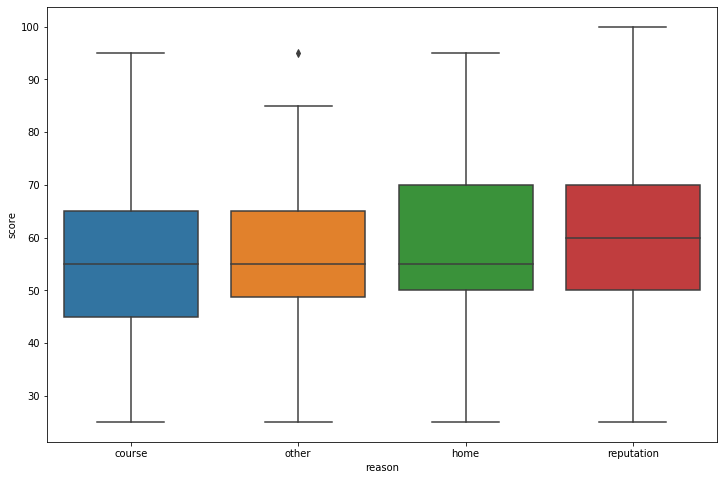

In [140]:
info_object(df.reason)

In [141]:
# Заполним пропуски самым частовстречаемым значением
df.reason.fillna('course', inplace=True)

        guardian
mother       213
father        77
other         17
Пропущенных значений - 28


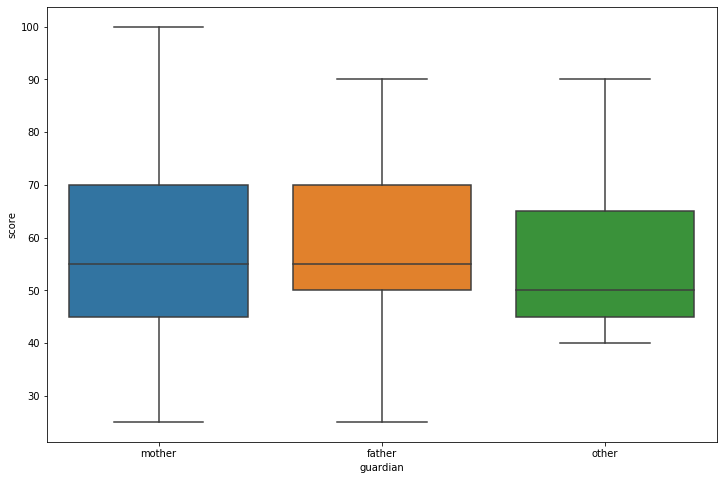

In [142]:
info_object(df.guardian)

In [143]:
# Заполним пропуски самым частовстречаемым значением
df.guardian.fillna('mother', inplace=True)

     schoolsup
no         281
yes         45
Пропущенных значений - 9


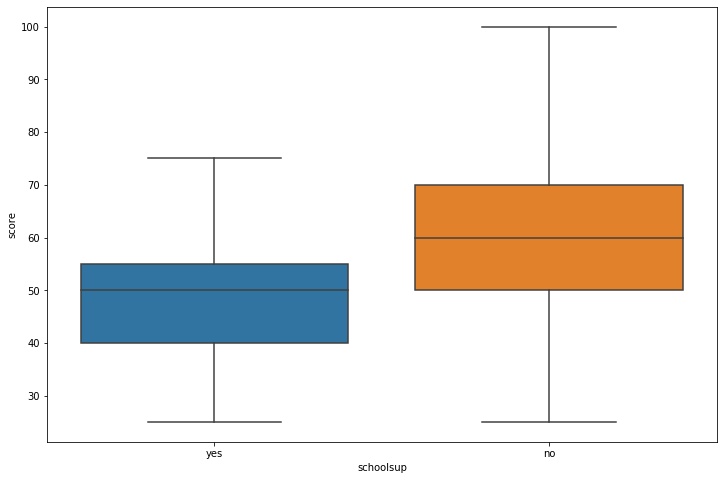

In [144]:
info_object(df.schoolsup)

In [145]:
# Заполним пропуски самым частовстречаемым значением
df.schoolsup.fillna('no', inplace=True)

     famsup
yes     187
no      116
Пропущенных значений - 32


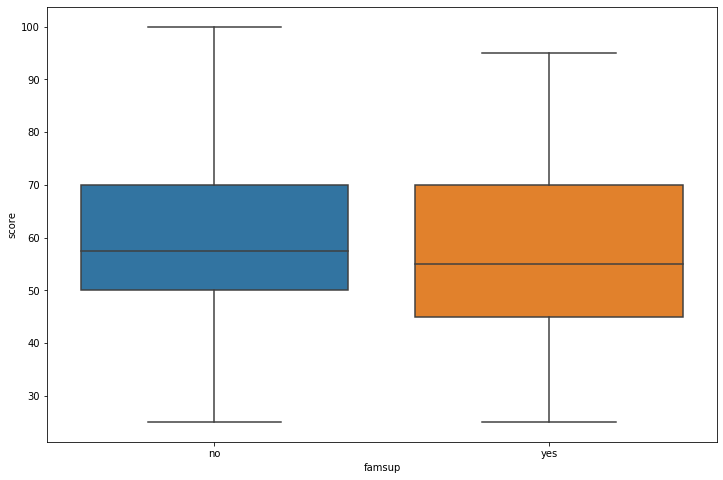

In [146]:
info_object(df.famsup)

In [147]:
# Заполним пропуски самым частовстречаемым значением
df.famsup.fillna('yes', inplace=True)

     paid
no    164
yes   136
Пропущенных значений - 35


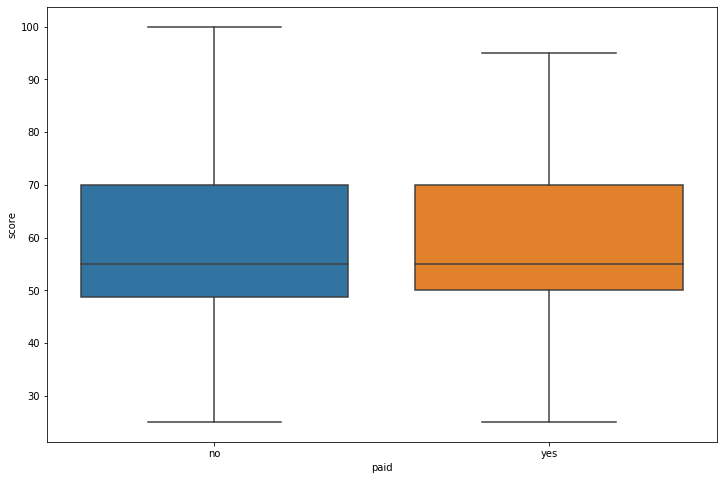

In [148]:
info_object(df.paid)

In [149]:
# Заполним пропуски самым частовстречаемым значением
df.paid.fillna('no', inplace=True)

     activities
yes         167
no          156
Пропущенных значений - 12


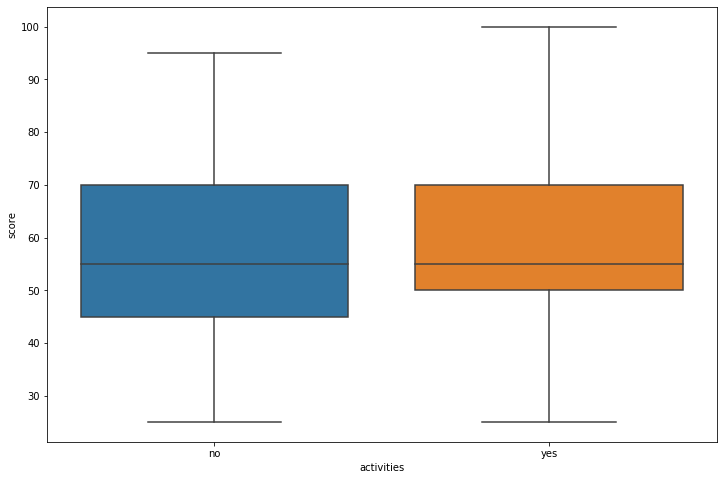

In [150]:
info_object(df.activities)

In [151]:
# Значения близкие, хочется распределить пропуски равномерно
# Заполним пропуски поочереди каждым значением

df.activities.fillna(0, inplace=True) # Заполним пропуски 0

for i in range(0, len(df)):
    counter = 0
    if df.activities[i] == 0:
        if counter % 2 == 0:
            df.activities[i] = 'yes'
            counter += 1
        else:
            df.activities[i] = 'no'
            counter += 1

     nursery
yes      258
no        65
Пропущенных значений - 12


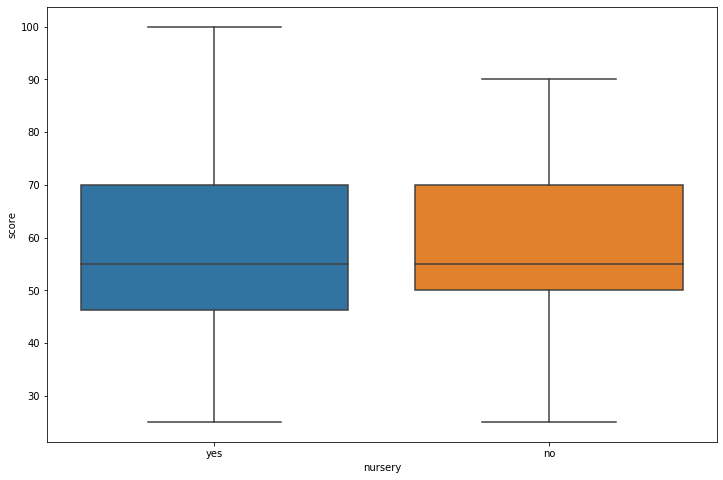

In [152]:
info_object(df.nursery)

In [153]:
# Заполним пропуски самым частовстречаемым значением
df.nursery.fillna('yes', inplace=True)

     higher
yes     305
no       12
Пропущенных значений - 18


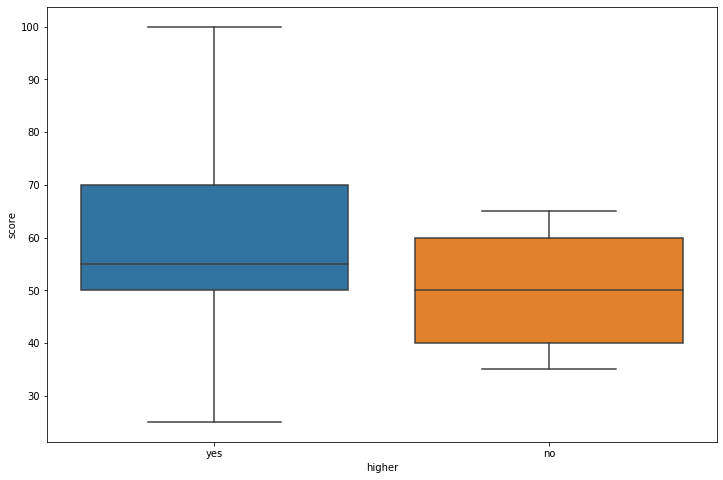

In [154]:
info_object(df.higher)

In [155]:
# Заполним пропуски самым частовстречаемым значением
df.higher.fillna('yes', inplace=True)

     internet
yes       259
no         48
Пропущенных значений - 28


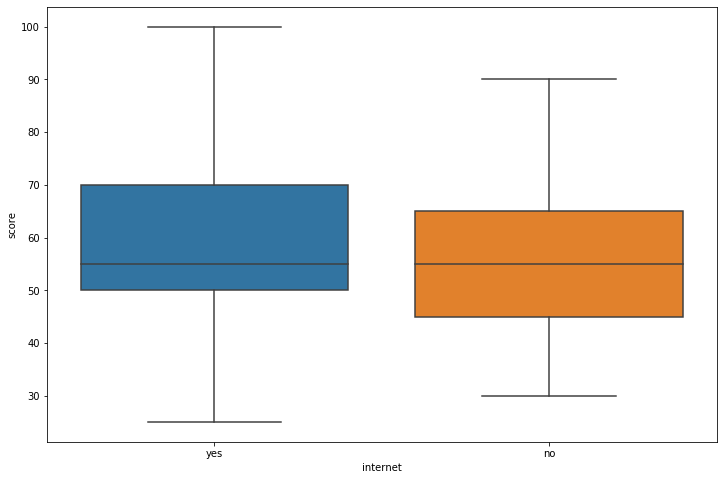

In [156]:
info_object(df.internet)

In [157]:
# Заполним пропуски самым частовстречаемым значением
df.internet.fillna('yes', inplace=True)

     romantic
no        213
yes        94
Пропущенных значений - 28


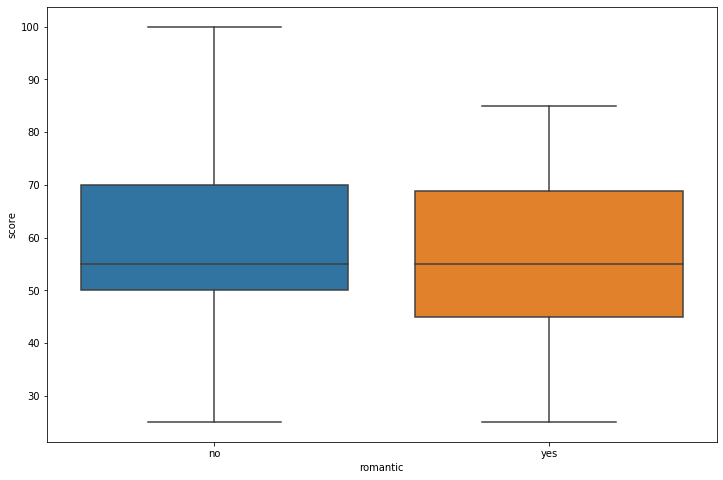

In [158]:
info_object(df.romantic)

In [159]:
# Заполним пропуски самым частовстречаемым значением
df.romantic.fillna('no', inplace=True)

In [160]:
# Финальная проверка на пропуски
df.isna().sum()

index                 0
school                0
sex                   0
age                   0
address               0
famsize               0
pstatus               0
medu                  0
fedu                  0
mjob                  0
fjob                  0
reason                0
guardian              0
traveltime            0
studytime             0
failures              0
schoolsup             0
famsup                0
paid                  0
activities            0
nursery               0
studytime_granular    0
higher                0
internet              0
romantic              0
famrel                0
freetime              0
goout                 0
health                0
absences              0
score                 0
dtype: int64

# Поиск зависимостей
Посмотрим корреляцию числовых значений

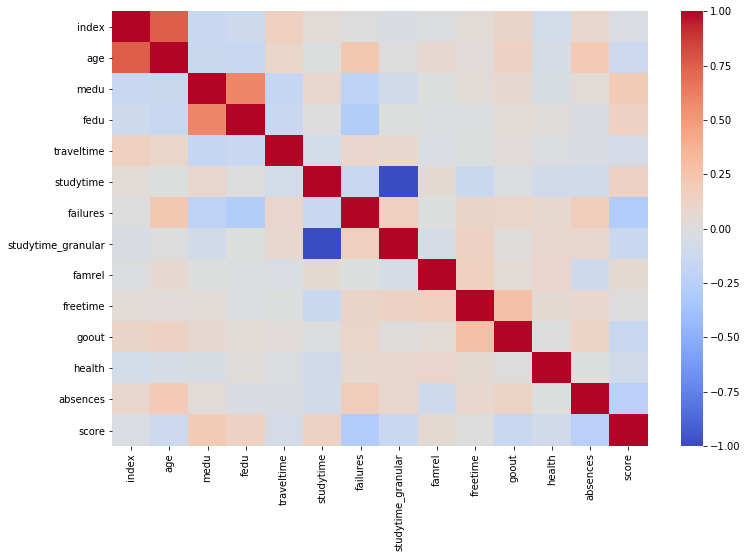

In [161]:
plt.rcParams['figure.figsize'] = (12,8)
sns.heatmap(df.corr(),cmap='coolwarm')

Полная корреляция столбцов studytime и studytime_granular позволяют не брать последний в рассчет.

Образование родителей (medu и fedu) и кол-во внеучебных неудач (failures) больше других оказывают влияние на успеваемость. Т.е. чем выше образование родителей, тем более успешный ребенок в жизни в целом, в том числе и в учебе. 

Также можно увидеть корреляцию возраста (age) и кол-ва внеучебных неудач (failures). Чем страше ребенок, тем хуже успеваемость. Можно предположить, что более молодые родители имеют лучшее образование, либо растущие дети начинают больше времени уделять друзьям (gout) а не учебе (studytime).

Присутствует также логическая связь влияния пропусков занятий (absences) на успеваемость, эти данные мы тоже возьмем в модель.

Еще раз построим графики и посмотрим на распределения категоральных данных

In [162]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()

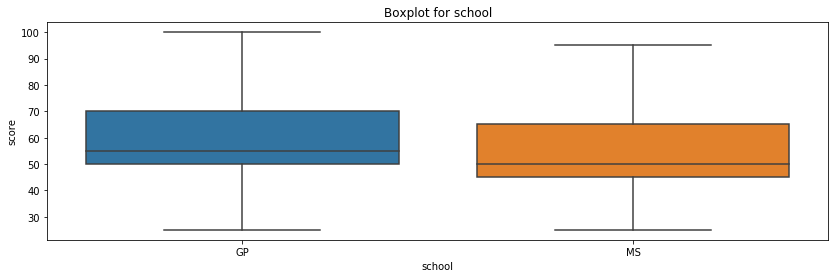

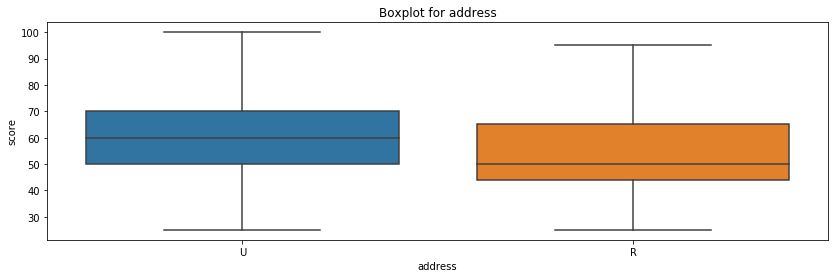

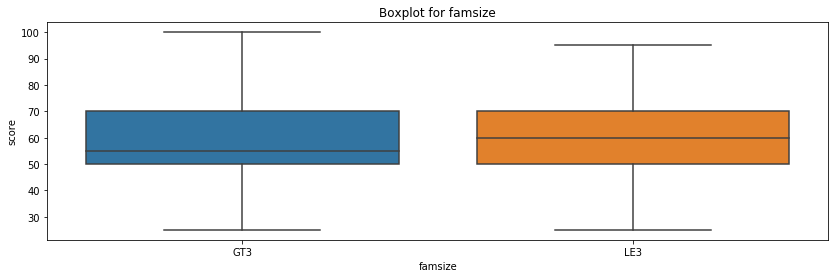

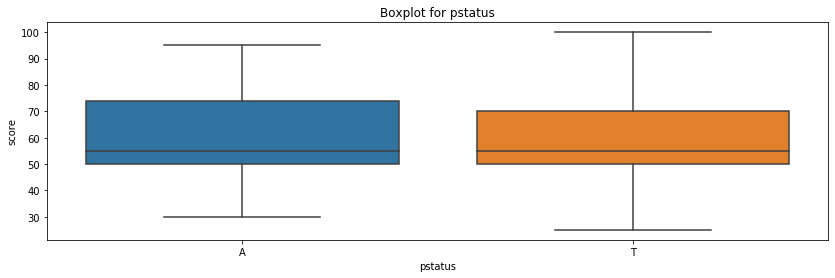

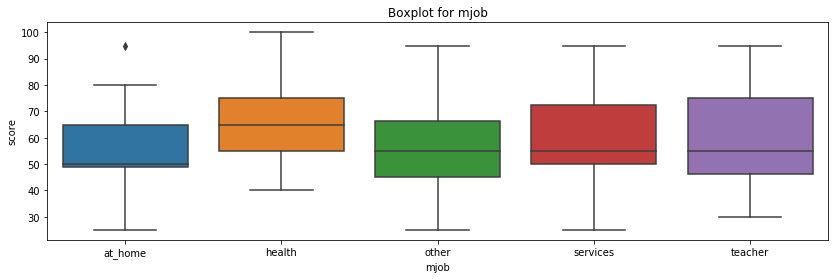

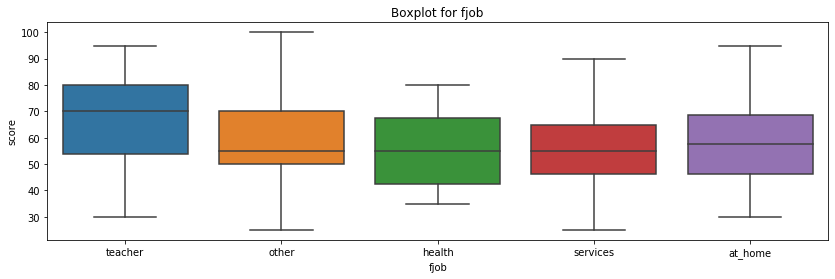

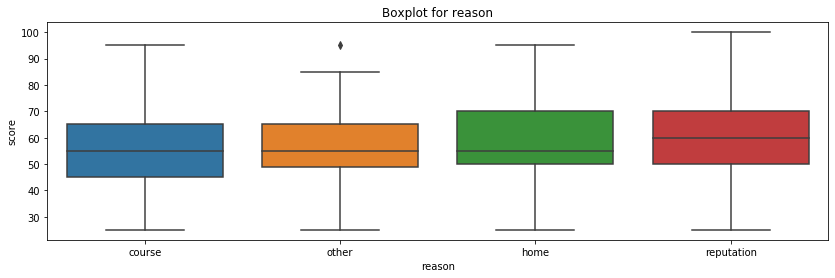

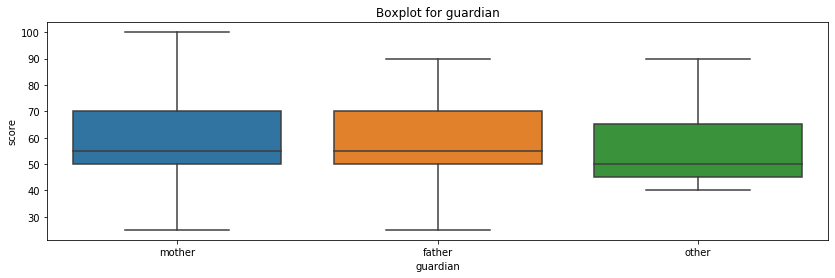

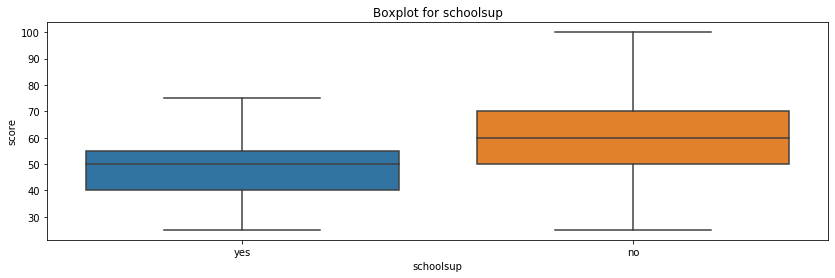

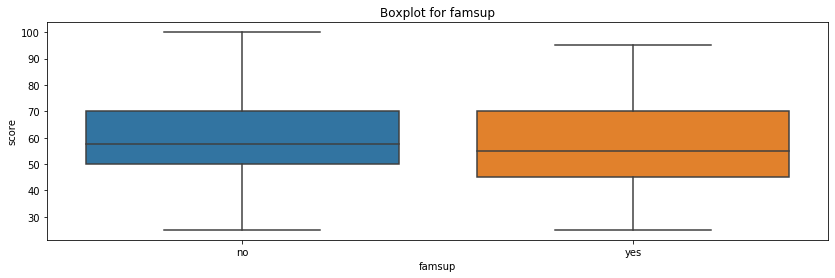

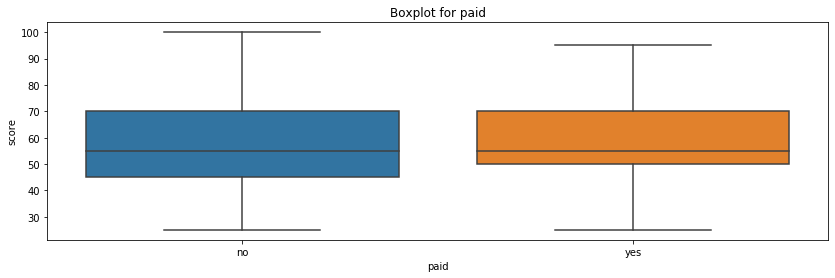

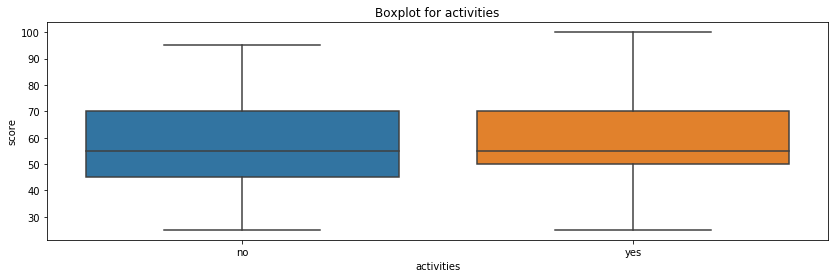

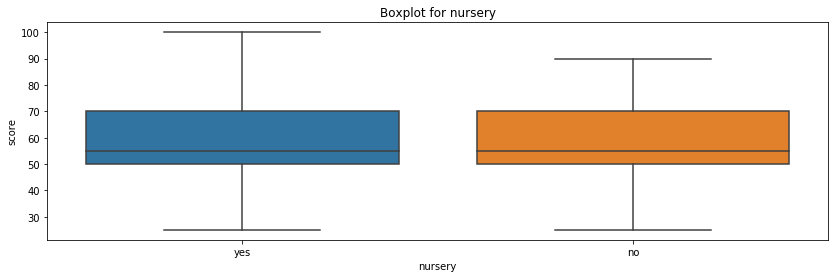

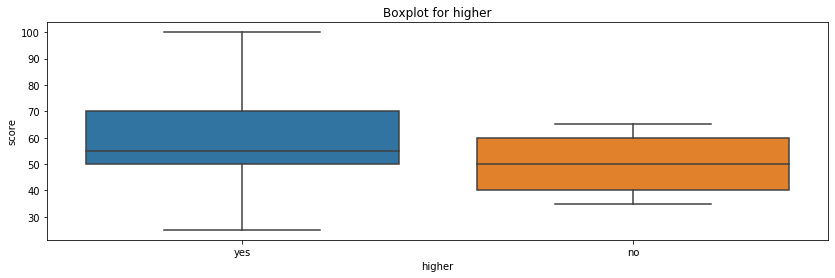

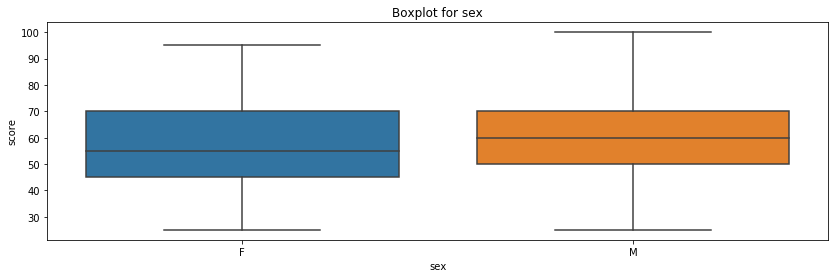

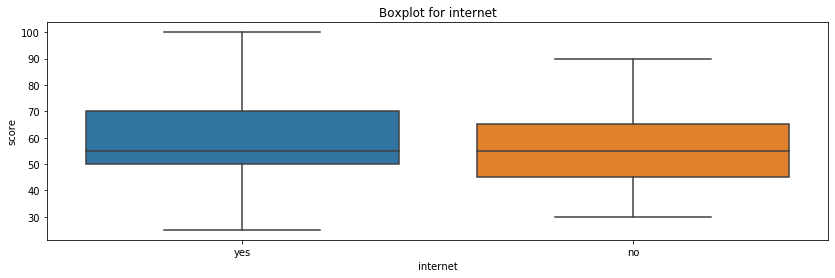

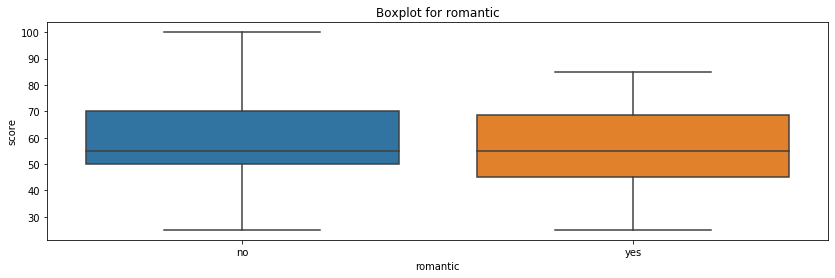

In [163]:
for col in ['school', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 
            'activities', 'nursery', 'higher', 'sex', 'internet', 'romantic']:
    get_boxplot(col)

По условию задачи поиска группы риска, оцениваем факторы влияющие на ухудшение успеваемости.
Из графиков мы видим, что минимальных значений больше у учащихся:
<ul>
    <li>школы GP</li>
    <li>живущих за городом (address)</li>
    <li>с размеров семьи больше 3 человек (famsize)</li>
    <li>родители которых проживают совместно (pstatus)
    <li>опекуном которых является мать (guardian) - статистическое большинство
    <li>без дополнительной образовательной поддержки
    <li>имеющих учебную поддержку дома (famsup)
    <li>не занимающихся дополнительно (платно) (paid)
    <li>посещавших детский сад
    <li>не собирающихся получать высшее образование (higher) - сильно влияет
    <li>женского пола
    <li>имеющих доступ к интернету
    <li>состоящих в романтических отношениях
</ul>

Сделаем тест Стюдента

In [164]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:20]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [165]:
for col in ['school', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
            'activities', 'nursery', 'higher', 'sex', 'internet', 'romantic']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки sex


### Собираем датасет для модели
Немного выводов:
<ol>
    <li>В целом, сильно влияет образование родителей. Они коррелируют достаточно сильно, но я решил не объединять, чтобы выявить будущие зависимости от пола родителей. Образование отца сильнее влияет на успеваемость, но также выделяется позиция матери преподавателя.</li>
    <li>Также сильно влияют на успеваемость планы учащегося поступать в высшее учебное заведение. Если таких планов нет - то и мотивация соответствующая.</li>
    <li>Остальные параметры в меньшей степени влияют на результат, но их сумма может оказать решающее воздействие.</li>
</ol>

In [166]:
model = df[['school','age','sex','address', 'medu', 'fedu', 'mjob', 'fjob', 'studytime', 'failures','romantic','schoolsup','higher', 'goout', 'absences', 'score']]
model

,school,age,sex,address,medu,fedu,mjob,fjob,studytime,failures,romantic,schoolsup,higher,goout,absences,score
0,GP,18,F,U,4.0,4.0,at_home,teacher,2.0,0.0,no,yes,yes,4.0,6.0,30.0
1,GP,17,F,U,1.0,1.0,at_home,other,2.0,0.0,no,no,yes,3.0,4.0,30.0
2,GP,15,F,U,1.0,1.0,at_home,other,2.0,3.0,no,yes,yes,2.0,10.0,50.0
3,GP,15,F,U,4.0,2.0,health,other,3.0,0.0,yes,no,yes,2.0,2.0,75.0
4,GP,16,F,U,3.0,3.0,other,other,2.0,0.0,no,no,yes,2.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,MS,18,F,U,3.0,1.0,teacher,services,2.0,0.0,no,no,yes,4.0,0.0,40.0
331,MS,17,M,U,3.0,1.0,services,services,1.0,0.0,no,no,yes,5.0,3.0,80.0
332,MS,21,M,R,1.0,1.0,other,other,1.0,3.0,no,no,yes,3.0,3.0,35.0
333,MS,18,M,R,3.0,2.0,services,other,1.0,0.0,no,no,yes,1.0,0.0,50.0
